# Module 1. Dataset Cleaning and Analysis


이 실습에서는 MovieLens 데이터 세트에서 수집된 데이터를 기반으로, 영화 추천 모델을 작성하는 법을 안내합니다.<br/>Module 1 에서는 MovieLens 데이터 세트를 가져와 각 피처들을 확인하고 데이터 클린징 및 분석 작업을 진행합니다.

## Notebook 사용법

코드는 여러 코드 셀들로 구성됩니다. 이 페이지의 상단에 삼각형으로 된 실행 단추를 마우스로 클릭하여 각 셀을 실행하고 다음 셀로 이동할 수 있습니다. 또는 셀에서 키보드 단축키 `Shift + Enter`를 눌러 셀을 실행하고 다음 셀로 이동할 수도 있습니다.

셀이 실행되면 셀이 실행되는 동안 측면에 줄이 * 표시되어 있거나 셀 내의 모든 코드를 예측한 후 실행이 완료된 마지막 셀을 나타내기 위해 숫자로 업데이트됩니다.

아래 지침을 따르고 셀을 실행하세요.

## Library Import 

파이썬에는 광범위한 라이브러리 모음이 포함되어 있으며, 본 LAB을 위해서 핵심 Data Scientist용 Tool 인 boto3 (AWS SDK) 및 Pandas/Numpy와 같은 라이브러리를 가져와야 합니다. 

In [1]:
import boto3
import json
import numpy as np
import pandas as pd
import time
import jsonlines
import os

from datetime import datetime
import sagemaker
import time
import warnings

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate
from botocore.exceptions import ClientError

다음으로 여러분의 환경이 Amazon Personalize와 성공적으로 통신할 수 있는지 확인해야 합니다.

In [2]:
# Configure the SDK to Personalize:
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')
s3 = boto3.resource('s3')

In [3]:
## Please fill the information below 
#WORK_DATE="<working date that will be used for prefix of solution names"
#data_dir = "<local data path>"
#BUCKET_NAME = "<your_bucket_name>"
#PREFIX="<prefix used for data stroage>"

WORK_DATE="20201215"
data_dir = "poc-data"
os.makedirs(data_dir+'/'+WORK_DATE,exist_ok=True)

account_id = "870180618679"
BUCKET_NAME = "jihys-personalize-ap-northeast-2"
PREFIX=WORK_DATE

INTERACTION_FILE="interation"
USER_FILE="user"
ITEM_FILE="item"


## 파일 다운로드

이번 HoL에 사용할 데이터 셋의 압축을 풉니다. 해당 데이터 셋은 [Movie Lense 데이터 셋](http://files.grouplens.org/datasets/movielens/ml-1m.zip) 을 변형한 데이터 입니다.

In [4]:
!unzip -o ml-1m-modified.zip

Archive:  ml-1m-modified.zip
   creating: data_ml_1m/
  inflating: data_ml_1m/users.dat    
  inflating: data_ml_1m/movies.csv   
  inflating: data_ml_1m/ratings.csv  
  inflating: data_ml_1m/README       


## 데이터 확인하기

Personalize 에서는 3종류의 데이터 셋을 인풋으로 사용 합니다.

1) **User**: 이 데이터 세트는 사용자에 대한 메타데이터를 저장합니다. 여기에는 맞춤화 시스템에서 중요한 신호가 될 수 있는 연령, 성별 및 충성도 멤버십 등의 정보가 포함될 수 있습니다.

2) **Item:** 이 데이터 세트는 항목에 대한 메타데이터를 저장합니다. 여기에는 가격, SKU 유형 또는 가용성과 같은 정보가 포함될 수 있습니다.

3) **Interaction:** 이 데이터 세트는 사용자와 항목 간의 상호 작용에서 나온 과거 및 실시간 데이터를 저장합니다.  이 데이터에는 사용자의 위치 또는 디바이스(모바일, 태블릿, 데스크톱 등)와 같은 사용자의 검색 컨텍스트에 대한 노출 데이터와 컨텍스트 메타데이터가 포함될 수 있습니다. Interaction 데이터셋은 모든 알고리즘에서 필수로 제공 해야하는 데이터 입니다. 
   
이번 실습에 사용할 파일의 컬럼에 대한 정보는 아래 README 파일을 통해 확인합니다.

In [5]:
!cat data_ml_1m/README

SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under the following conditions:

     * The user may not state or imply any endorsement from the
       University of Minnesota or the GroupLens Research Group.

     * The user must acknowledge the use of the data set in
       publications resulting from the use of the data set
       (see below for citation information).

     * The user may not redistribute the data without separate
       permission.

     * The user may not use this information for any commercial or
       revenue-bearing purposes without first obtaining permission
       from a facult

In [6]:
df=pd.read_csv('data_ml_1m/ratings.csv')
df.columns=["USER_ID","ITEM_ID","EVENT_VALUE", "TIMESTAMP"]
df['EVENT_TYPE']='RATING'
df.head()

,USER_ID,ITEM_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
0,11,1188,4,978220319,RATING
1,11,587,3,978219045,RATING
2,11,1265,3,978219815,RATING
3,11,2712,1,978220669,RATING
4,11,1198,4,978218913,RATING


In [7]:
item=pd.read_csv('data_ml_1m/movies.csv')
item.columns=['ITEM_ID', 'TITLE', 'GENRE']
item.head()

,ITEM_ID,TITLE,GENRE
0,1,Toy Story (1995),Animation.Children's.Comedy
1,2,Jumanji (1995),Adventure.Children's.Fantasy
2,3,Grumpier Old Men (1995),Comedy.Romance
3,4,Waiting to Exhale (1995),Comedy.Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
user=pd.read_csv('data_ml_1m/users.dat',sep='::',encoding='latin1',names=['USER_ID', 'GENDER','AGE', 'OCCUPATION','ZIPCODE'])
user.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,USER_ID,GENDER,AGE,OCCUPATION,ZIPCODE
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## 데이터 클린징

여기에서는 아래와 같은 데이터 클린징 작업을 합니다.
  
- Null/Duplicated 데이터 정리
- 인터렉션 데이터중 메타데이터에 없는 데이터 삭제 

### NULL Data 및 Duplicated Data 확인 및 삭제
인터렉션 데이터를 조사해 보면 많은 중복 데이터가 존재합니다. 특히나 Interaction data 로그에서 이러한 패턴을 많이 보입니다. 
여기서는 불필요한 중복 데이터를 삭제합니다. 또한 TIMESTAMP와 USER_ID, ITEM_ID와 같이 필수 데이터가 null 인 데이터를 제거하도록 합니다.

단 Amazon Personalize에서는 Amazon Personalize 솔루션에서 생성할 때 일부 메타데이터에 한 해 "null"을 허용된 메타데이터 값으로 정의할 수 있습니다. 예를 들어 interaction data의 EVENT_TYPE, item 혹은 user data의 메타 데이터 값에서는 "null"을 허용합니다. "null" 을 허용된 값으로 사용하기 위해서는 스키마 정의시 null 을 허용하도록 세팅 하여야 합니다.
~~~

{
  "type": "record",
  "name": "Items",
  "namespace": "com.amazonaws.personalize.schema",
  "fields": [
    {
      "name": "ITEM_ID",
      "type": "string"
    },
    {
      "name": "GENRES",
      "type": [
        "null",
        "string"
      ],
      "categorical": true
    },
    {
      "name": "CREATION_TIMESTAMP",
      "type": "long"
    }
  ],
  "version": "1.0"
}
~~~

Amazon Personalize는 솔루션을 생성하면서 누락된 메타데이터가 있는 필드를 자동으로 인식하고 기계 학습 모델을 훈련할 때 적절하게 처리합니다.자세한 내용은 [여기](https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html#dataset-requirements) 를 참고해 주세요. 

In [9]:
#interactin data null 데이터 확인 
print("# of rows of Null TimeStamp : {}".format(df['TIMESTAMP'].isnull().sum()))
print("# of rows of Null User ID : {}".format(df['USER_ID'].isnull().sum()))
print("# of rows of Null Item ID : {}".format(df['ITEM_ID'].isnull().sum()))
# interaction null 데이터 삭제
df=df.dropna(subset=['TIMESTAMP','USER_ID','ITEM_ID'])

# of rows of Null TimeStamp : 0
# of rows of Null User ID : 0
# of rows of Null Item ID : 0


In [10]:
#interaction 중복 데이터 확인 
print("duplicated rows:", len(df[df.duplicated(keep=False)]))
#interaction 중복 데이터 제거
df=df.drop_duplicates()

duplicated rows: 40


In [11]:
#item에서 ITEM_ID가 null 인 행을 제거 
print("# of rows of Null Item ID : {}".format(item['ITEM_ID'].isnull().sum()))
item=item.dropna(subset=['ITEM_ID'])
#item meta 중복 데이터 확인
print("duplicated rows:", len(item[item.duplicated(keep=False)]))
#item meta 중복 데이터 제거
item=item.drop_duplicates()

# of rows of Null Item ID : 0
duplicated rows: 0


In [12]:
#user에서 USER_ID가 null 인 행을 제거 
print("# of rows of Null User ID : {}".format(df['USER_ID'].isnull().sum()))
user=user.dropna(subset=['USER_ID'])
#user meta 중복 데이터 확인
print("duplicated rows:", len(user[user.duplicated(keep=False)]))
#user meta 중복 데이터 제거
user=user.drop_duplicates()

# of rows of Null User ID : 0
duplicated rows: 0


### 인터렉션 데이터중 메타데이터에 없는 데이터 삭제


#### Item Metadata 에 없는 인터렉션 삭제하기 
- Item metadata에 없는 아이템 아이디를 제외한 인터렉션 테이블을 추려냅니다.<br/> (이번 샘플 데이터 셋에는 위같은 데이터가 존재하진 않습니다.)<br/>
`unique_item_from_df=df['ITEM_ID'].unique()`<br/>
`unique_item_from_meta=item['ITEM_ID'].unique()`

- 아래 코드를 실행하여 Item metadata에 없는 인터렉션 정보를 확인합니다. <br/>
`assert(len(df[- df['ITEM_ID'].isin(unique_item_from_meta)])==0)`
- 해당 인터렉션 라인을 삭제 합니다. <br/>
`df= df[df['ITEM_ID'].isin(unique_item_from_meta)] `

비슷한 방식으로 User metadata에 없는 사용자를 제거 할수도 있습니다.<br/>
* `unique_user_from_df=df['USER_ID'].unique()`<br/>
* `unique_user_from_meta=user['USER_ID'].unique()`<br/>
* `assert(len(df[- df['USER_ID'].isin(unique_user_from_meta)])==0)`<br/>
* `df= df[df['USER_ID'].isin(unique_user_from_meta)] `<p/>

In [13]:
unique_item_from_df=df["ITEM_ID"].unique()
unique_item_from_meta=item['ITEM_ID'].unique()
print("Unique items from interaction:",len(unique_item_from_df))
print("Unique items from item metadata:", len(unique_item_from_meta))


Unique items from interaction: 3678
Unique items from item metadata: 3883


In [14]:
assert(len(df[- df['ITEM_ID'].isin(unique_item_from_meta)])==0)
#df=df[df['ITEM_ID'].isin(unique_item_from_meta)]

### Multi-Category 데이터 준비 
영화 장르와 같이 여러 장르로 구분할 수 있는 데이터는 '|'로 구분되어 표기되어야 합니다. <br/> 
아래 코드는 '.'으로 구분되어 있는 구분자를 '|'로 대체 할 수 있습니다. 
자세한 내용은 [여기](https://docs.aws.amazon.com/ko_kr/personalize/latest/dg/data-prep-formatting.html)를 클릭하여 확인합니다.
![image.png](images/image1.png)



In [15]:
#Multi label 
for idx,i in enumerate(item["GENRE"]):
        item["GENRE"][idx]=i.replace('.', '|') 
item.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,ITEM_ID,TITLE,GENRE
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


##  INTERACTION DATA 정보 확인

Personalize에서 학습을 수행하기 위해서는 다음과 [official limits](https://docs.aws.amazon.com/personalize/latest/dg/limits.html)같은 데이터 요구사항을 맞추어야 합니다. 

* 최소 25명 고유 사용자 
* 최소 100개 고유 아이템 
* 사용자 당 2개 이상의 Interaction(예. 구매,평가 등) 기록


하지만 일반적으로 다음과 같은 데이터가 준비 되어 있는것이 좋습니다. 

* 최소 50명 고유 사용자 
* 최소 100개 고유 아이템 
* 사용자 당 24 이상의 Interaction(예. 구매,평가 등) 기록

### 사용자 평점 분포하기

여기에서는 사용자 평점 분포를 확인합니다. 
사용자 평점이 1,2 인 경우 사용자가 선호하는 아이템으로 확인하기 어렵기 때문에 여기 핸즈온에서는 3점 이상인 벨류만 사용하도록 합니다.

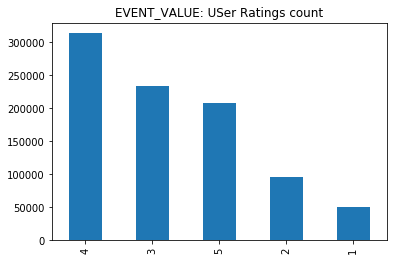

In [16]:
# Print User Rating Value counts
df.EVENT_VALUE.value_counts().plot(kind='bar')
plt.title("EVENT_VALUE: USer Ratings count")
plt.show()

In [17]:
df=df[df['EVENT_VALUE']>=3]

### 인터렉션의 사용자 정보 분석 

User personalization 계열의 추천 알고리즘에서는 학습에 포함할 Percentile을 조정할 수 있는 파라메터(min_user_history_length_percentile, max_user_history_length_percentile)가 있습니다. 
너무 인터렉션이 많은 사용자는 데이터에 노이즈를 포함되는 경우가 있기 때문에 제외하는 것이 좋습니다. 또한 너무 인터렉션이 적은 사용자 또한 제대로된 추천 기록을 받기 어렵기 때문에 제외하는것이 좋습니다. Default로는 min max 값은 0과 0.99로 세팅되어 있습니다.
예를 들어 min_user_history_length_percentile to 0.05 및 max_user_history_length_percentile to 0.95 설정에는 기록 길이가 하위 또는 상위 5%에 해당하는 사용자를 제외한 모든 사용자가 포함됩니다.

In [18]:
## checkout the unique number of users and items in the interaction
unique_user_from_df=df['USER_ID'].unique()
unique_item_from_df=df['ITEM_ID'].unique()
print("Unique User from interaction:", len(unique_user_from_df))
print("Unique Item from interaction:",len(unique_item_from_df))
unique_user_from_meta=user["USER_ID"].unique()
unique_item_from_meta=item["ITEM_ID"].unique()
print("Unique User from usermeta", len(unique_user_from_meta))
print("Unique Item from itemmeta:",len(unique_item_from_meta))


Unique User from interaction: 6023
Unique Item from interaction: 3590
Unique User from usermeta 6040
Unique Item from itemmeta: 3883


In [19]:
user_activity_counts = df.groupby("USER_ID").count().loc[:,["EVENT_VALUE"]].rename(columns={"EVENT_VALUE":"INTERACTION_COUNTS"})
user_activity_counts

,INTERACTION_COUNTS
USER_ID,
11,34
12,21
13,100
14,18
15,166
...,...
6036,708
6037,189
6038,18


In [20]:
user_activity_counts.quantile([0.01,0.05,.1,.2,.3,.4,.5,.6,.8,.9,.95,.99,.999,.9999,1.0])

,INTERACTION_COUNTS
0.0100,8.0000
0.0500,18.0000
0.1000,22.0000
0.2000,30.0000
0.3000,41.0000
0.4000,56.0000
0.5000,74.0000
0.6000,100.0000
0.8000,193.0000
0.9000,298.0000


In [21]:
user_activity_counts=user_activity_counts.reset_index()
activities = user_activity_counts.groupby('INTERACTION_COUNTS').count()
activities.columns=['NUM_USERS']

In [22]:
activities['NUM_USERS'].sum()
assert (len(unique_user_from_df)==activities['NUM_USERS'].sum())

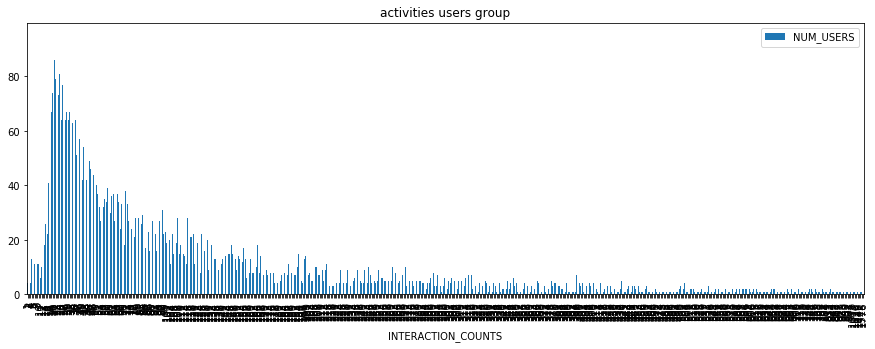

In [23]:
activities.plot(kind='bar',figsize=(15,5))
#activities.loc[:,:].plot(kind='bar', figsize=(15,5), ylim=(0,5496))
plt.title("activities users group")

plt.show()

In [24]:
print("Number of Users in Activities counts @Max Frequency of {}:".format(activities['NUM_USERS'].idxmax()),activities['NUM_USERS'].max())

Number of Users in Activities counts @Max Frequency of 22: 95


In [25]:
activities[activities.index > 24].NUM_USERS.sum()

5225

### 인터렉션의 아이템 분석

In [26]:
print(df.head())
df.ITEM_ID = df.ITEM_ID.astype(str)

   USER_ID  ITEM_ID  EVENT_VALUE  TIMESTAMP EVENT_TYPE
0       11     1188            4  978220319     RATING
1       11      587            3  978219045     RATING
2       11     1265            3  978219815     RATING
4       11     1198            4  978218913     RATING
5       11      593            5  978219607     RATING


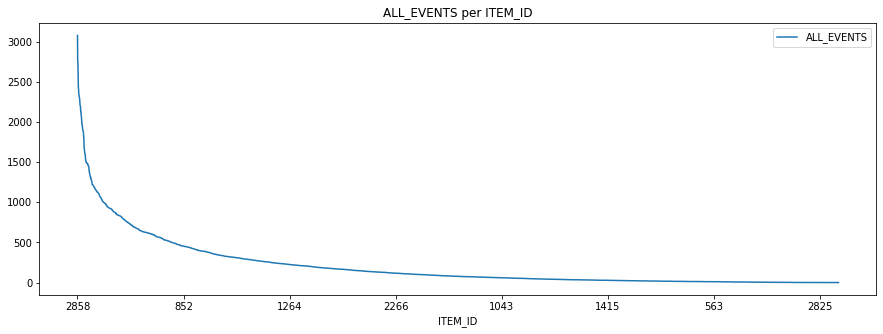

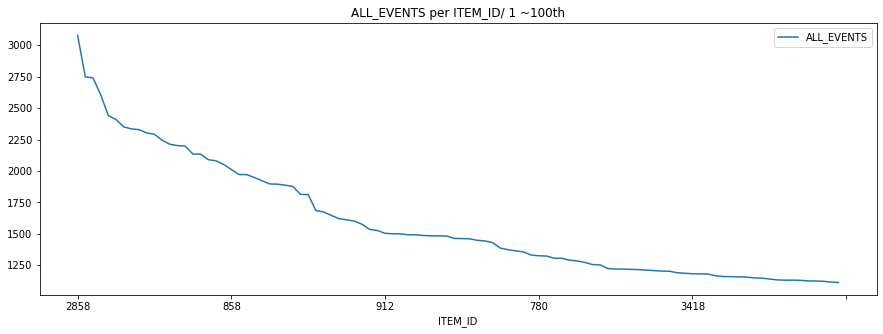

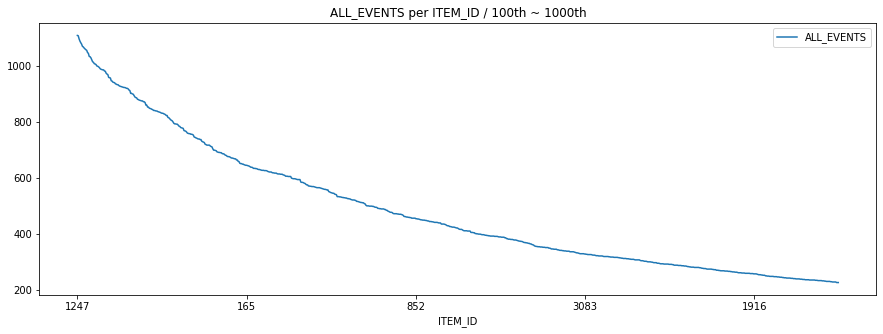

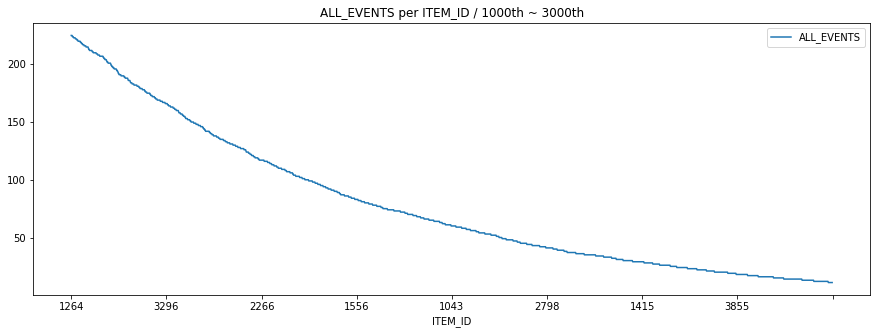

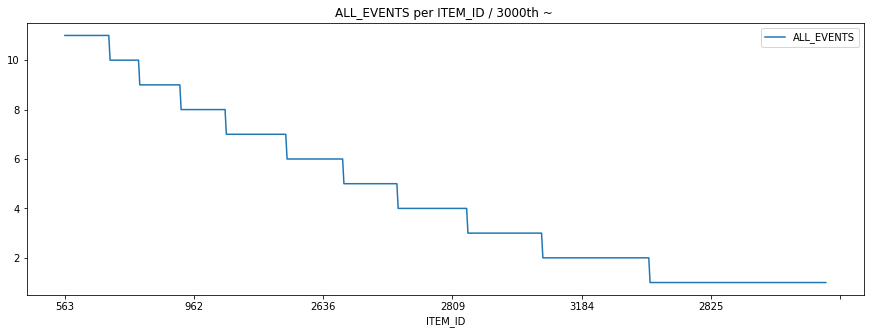

In [27]:
def draw_long_tails(df, is_in_event_types, groupby_column_name, count_name, range1=100, range2=1000, range3=3000):
    filtered_df = df.loc[df["EVENT_VALUE"].isin(is_in_event_types)]
    #print(filtered_df.head())
    groupby_df = filtered_df.groupby(groupby_column_name).count().loc[:,["EVENT_VALUE"]].rename(columns={"EVENT_VALUE":count_name})
    #print(groupby_df.head())
    sorted_df = groupby_df.sort_values([count_name], ascending=False)
    #print(sorted_df.head())
    sorted_df.plot(kind='line', figsize=(15,5))
    plt.title(count_name + " per " + groupby_column_name)
    plt.show()
 
    sorted_df[:range1].plot(kind='line', figsize=(15,5))
    plt.title(count_name + " per " + groupby_column_name + "/ 1 ~" + str(range1) + "th")
    plt.show()
    
    sorted_df[range1:range2].plot(kind='line', figsize=(15,5))
    plt.title(count_name + " per " + groupby_column_name + " / " + str(range1) + "th ~ "+ str(range2) + "th")
    plt.show()

    sorted_df[range2:range3].plot(kind='line', figsize=(15,5))
    plt.title(count_name + " per " + groupby_column_name + " / " + str(range2) + "th ~ "+ str(range3) + "th")
    plt.show()
    
    sorted_df[range3:].plot(kind='line', figsize=(15,5))
    plt.title(count_name + " per " + groupby_column_name + " / " + str(range3) + "th ~ ")
    plt.show()
   
    
    
#draw_long_tails(df, ["ORDER","VIEW_DETAIL","ADD_CART"], "ITEM_ID", "ALL_EVENTS", 100, 1000, 3000)    
draw_long_tails(df, ["5","4","3"], "ITEM_ID", "ALL_EVENTS", 100, 1000, 3000)    


## 사용자 메타 데이터 분석

In [28]:
print(user.head())
user.describe()

   USER_ID GENDER  AGE  OCCUPATION ZIPCODE
0        1      F    1          10   48067
1        2      M   56          16   70072
2        3      M   25          15   55117
3        4      M   45           7   02460
4        5      M   25          20   55455


,USER_ID,AGE,OCCUPATION
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


In [29]:
user_GENDER_counts = user.groupby('GENDER').count().loc[:,["USER_ID"]].rename(columns={"USER_ID":"GENDER_COUNTS"})
user_GENDER_counts

,GENDER_COUNTS
GENDER,
F,1709
M,4331


In [30]:
user_AGE_counts = user.groupby('AGE').count().loc[:,["USER_ID"]].rename(columns={"USER_ID":"AGE_COUNTS"})
user_AGE_counts

,AGE_COUNTS
AGE,
1,222
18,1103
25,2096
35,1193
45,550
50,496
56,380


In [31]:
user_OCCUPATION_counts = user.groupby('OCCUPATION').count().loc[:,["USER_ID"]].rename(columns={"USER_ID":"OCCUPATION_COUNTS"})
user_OCCUPATION_counts

,OCCUPATION_COUNTS
OCCUPATION,
0,711
1,528
2,267
3,173
4,759
5,112
6,236
7,679
8,17


In [32]:
user_ZIPCODE_counts = user.groupby('ZIPCODE').count().loc[:,["USER_ID"]].rename(columns={"USER_ID":"ZIPCODE_COUNTS"})
user_ZIPCODE_counts

,ZIPCODE_COUNTS
ZIPCODE,
00231,1
00606,1
00681,1
00693,1
00918,1
...,...
99703,1
99709,1
99801,1


AGE,GENDER,OCCUPATION은 전체 사용자 수 6023명 대비 비교적낮은 캐터고리 개수(Cardinality)가 존배합니다. 
하지만 zipcode 경우 3439개로 너무 높습니다. 따라서 이후 학습시에는 사용하지 않도록 합니다. 

In [33]:
user=user.drop(['ZIPCODE'],axis=1)
user.head()

,USER_ID,GENDER,AGE,OCCUPATION
0,1,F,1,10
1,2,M,56,16
2,3,M,25,15
3,4,M,45,7
4,5,M,25,20


## ITEM 메타 데이터 분석

In [34]:
item.head()

,ITEM_ID,TITLE,GENRE
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [35]:
item.ITEM_ID = item.ITEM_ID.astype(str)

In [36]:
item_genre_counts = item.groupby('GENRE').count().loc[:,["ITEM_ID"]].rename(columns={"ITEM_ID":"GENRE_COUNTS"})
item_genre_counts 

,GENRE_COUNTS
GENRE,
Action,65
Action|Adventure,25
Action|Adventure|Animation,1
Action|Adventure|Animation|Children's|Fantasy,1
Action|Adventure|Animation|Horror|Sci-Fi,1
...,...
Sci-Fi|Thriller|War,1
Sci-Fi|War,1
Thriller,101


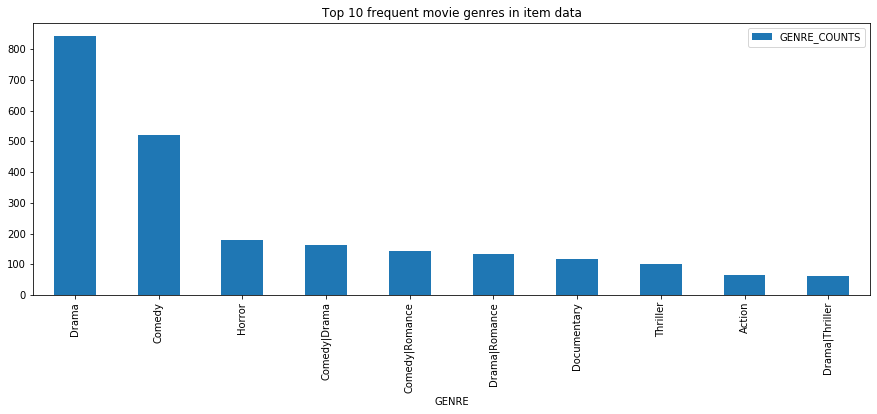

In [37]:
sorted_item = item_genre_counts.sort_values("GENRE_COUNTS", ascending=False)
sorted_item[:10].plot(kind='bar',figsize=(15,5))
plt.title("Top 10 frequent movie genres in item data")
plt.show()

In [38]:
item_file=data_dir+'/'+WORK_DATE+'/'+'item.csv'
user_file=data_dir+'/'+WORK_DATE+'/'+'user.csv'
inter_file=data_dir+'/'+WORK_DATE+'/'+'intercation.csv'

item.to_csv(item_file,index=False)
user.to_csv(user_file,index=False)
df.to_csv(inter_file,index=False)

In [39]:
%store WORK_DATE
%store data_dir
%store account_id 
%store BUCKET_NAME 
%store PREFIX
%store item_file
%store user_file
%store inter_file

Stored 'WORK_DATE' (str)
Stored 'data_dir' (str)
Stored 'account_id' (str)
Stored 'BUCKET_NAME' (str)
Stored 'PREFIX' (str)
Stored 'item_file' (str)
Stored 'user_file' (str)
Stored 'inter_file' (str)
